In [1]:
# Set up for running on Colab (If imports fail restart runtime)
%cd /content/drive/MyDrive/challenge/code
import sys
sys.path.append('/content/drive/MyDrive/challenge/code')

/content/drive/MyDrive/challenge/code


In [2]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Custom module imports
import data_utils
import models

# Functions to keep notebook readable
from notebook_utils import find_compound_kinase_pairs_with_both_measurements, get_2metric_comparison_series, find_multi_kinase_compound_responses, get_2kinase_comparison_series

## Exploratory Data Analysis

Firstly, I want to predict pKi, but have lots of data that uses the pIC50 metric. I understand these are related, but if I know more about *how* they are related I can think of ways to create a model that is agnostic to the output metric used.


### How do pKi and pIC50 compare for the same compound and same kinase?

[]

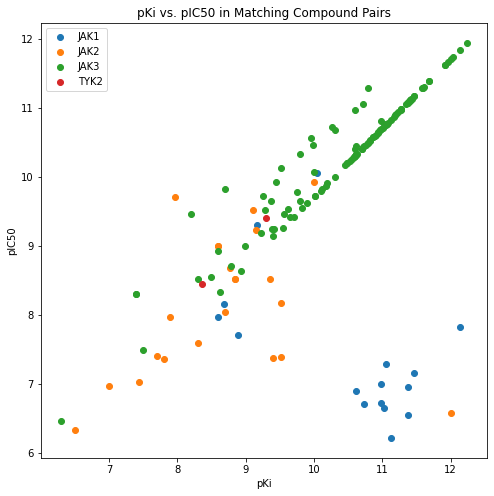

In [3]:
# See if there is any linear relationship between pKi and IC50. 
# First determine if there are some samples in which we have the same compund, 
# protein, and both measurement types.

# Load
data = pd.read_csv("/content/drive/MyDrive/challenge/kinase_JAK.csv")

# Find valid pairs
comparison_pairs = find_compound_kinase_pairs_with_both_measurements(data)

# Create series of matching pairs for a given kinase
pKi_j1, pIC50_j1 = get_2metric_comparison_series(["JAK1"], comparison_pairs)
pKi_j2, pIC50_j2 = get_2metric_comparison_series(["JAK2"], comparison_pairs)
pKi_j3, pIC50_j3 = get_2metric_comparison_series(["JAK3"], comparison_pairs)
pKi_t, pIC50_t = get_2metric_comparison_series(["TYK2"], comparison_pairs)

# Plot
plt.figure(figsize=(8,8))
plt.scatter(pKi_j1, pIC50_j1, label="JAK1")
plt.scatter(pKi_j2, pIC50_j2, label="JAK2")
plt.scatter(pKi_j3, pIC50_j3, label="JAK3")
plt.scatter(pKi_t, pIC50_t, label="TYK2")
plt.title("pKi vs. pIC50 in Matching Compound Pairs")
plt.xlabel("pKi")
plt.ylabel("pIC50")
plt.legend()
plt.plot()

There is a strong linearity in JAK3 and TYK2 for the examples I could assemble, a weaker linear trend for JAK2 and no positive linear trend for JAK1. Making an assumption that pKi and pIC50 are roughly equivalent would greatly simplify the model. For the scope of this assessment, I feel comfortable making that assumption for all kinases except JAK1. This is a problem because JAK1 is the most represented kinase in the dataset, so I will now investigate JAK1 further.

### What is the range of JAK1 responses compared to the other kinases?

[]

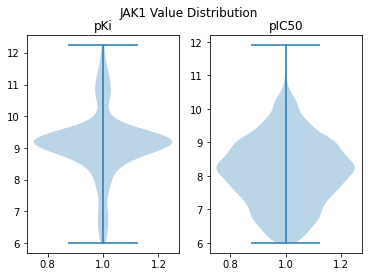

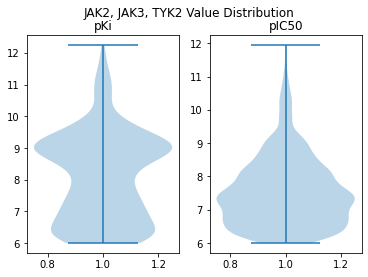

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('JAK1 Value Distribution')
ax1.set_title('pKi');ax2.set_title('pIC50')
ax1.violinplot(data[(data["Kinase_name"]=="JAK1") & (data["measurement_type"]=="pKi")]["measurement_value"])
ax2.violinplot(data[(data["Kinase_name"]=="JAK1") & (data["measurement_type"]=="pIC50")]["measurement_value"])
plt.plot()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('JAK2, JAK3, TYK2 Value Distribution')
ax1.set_title('pKi');ax2.set_title('pIC50')
ax1.violinplot(data[(data["Kinase_name"] != "JAK1") & (data["measurement_type"]=="pKi")]["measurement_value"])
ax2.violinplot(data[(data["Kinase_name"] != "JAK1") & (data["measurement_type"]=="pIC50")]["measurement_value"])
plt.plot()

In addition to not having a strong linear trend, the JAK1 has a slightly more concentrated distribution of values than the other kinases but probably not enough to use this for feature engineering. I will proceed with the assumption that pKi and pIC50 are roughly linearlly correlated for the purpose of this analysis.

### Correlation of Multiple Kinase Response to Same Compound
Related proteins may still have different responses to the same binding compound. If the responses are too different, it is possible that the only way to proceed would be to create and train separate models for each kinase. Below, I will try to determine for the cases in which we have the same type of score, and the same compound, how correlated the scores are.

Text(0.5, 1.0, 'JAK3 vs TYK2 R2 = 0.101')

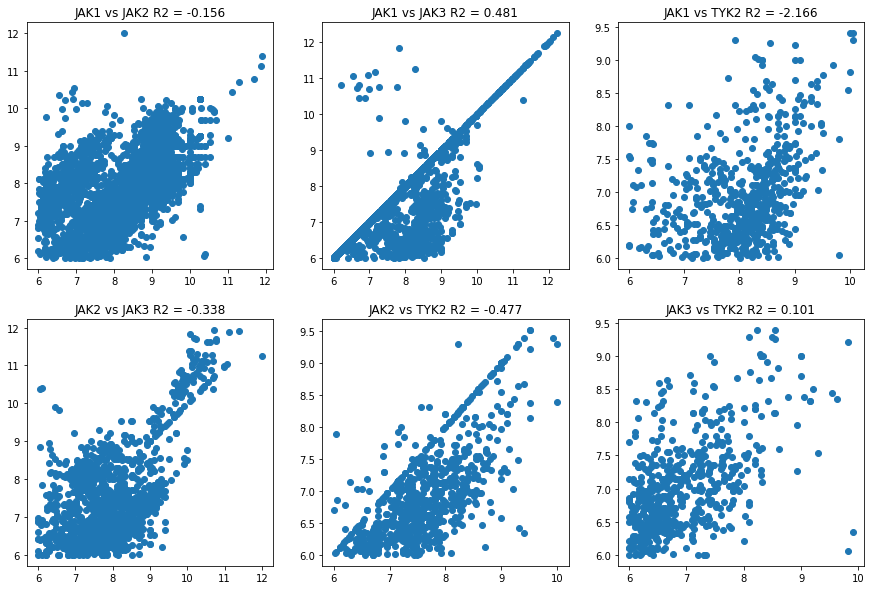

In [5]:
# Find pairs in which there is the same measurement type for at least 2 compounds
multi_kinase_compound_pairs = find_multi_kinase_compound_responses(data)

# Plot relationships between pairwise kinases on common compounds
j12_j1, j12_j2 = get_2kinase_comparison_series('JAK1', 'JAK2', multi_kinase_compound_pairs)
j13_j1, j13_j3 = get_2kinase_comparison_series('JAK1', 'JAK3', multi_kinase_compound_pairs)
j14_j1, j14_j4 = get_2kinase_comparison_series('JAK1', 'TYK2', multi_kinase_compound_pairs)
j23_j2, j23_j3 = get_2kinase_comparison_series('JAK2', 'JAK3', multi_kinase_compound_pairs)
j24_j2, j24_j4 = get_2kinase_comparison_series('JAK2', 'TYK2', multi_kinase_compound_pairs)
j34_j3, j34_j4 = get_2kinase_comparison_series('JAK3', 'TYK2', multi_kinase_compound_pairs)

fig, ax = plt.subplots(nrows=2, ncols=3)

fig.set_figheight(10)
fig.set_figwidth(15)

ax[0][0].scatter(j12_j1, j12_j2)
ax[0][0].set_title("JAK1 vs JAK2 {}".format("R2 = {:.3f}".format(metrics.r2_score(j12_j1, j12_j2))))
ax[0][1].scatter(j13_j1, j13_j3)
ax[0][1].set_title("JAK1 vs JAK3 {}".format("R2 = {:.3f}".format(metrics.r2_score(j13_j1, j13_j3))))
ax[0][2].scatter(j14_j1, j14_j4)
ax[0][2].set_title("JAK1 vs TYK2 {}".format("R2 = {:.3f}".format(metrics.r2_score(j14_j1, j14_j4))))
ax[1][0].scatter(j23_j2, j23_j3)
ax[1][0].set_title("JAK2 vs JAK3 {}".format("R2 = {:.3f}".format(metrics.r2_score(j23_j2, j23_j3))))
ax[1][1].scatter(j24_j2, j24_j4)
ax[1][1].set_title("JAK2 vs TYK2 {}".format("R2 = {:.3f}".format(metrics.r2_score(j24_j2, j24_j4))))
ax[1][2].scatter(j34_j3, j34_j4)
ax[1][2].set_title("JAK3 vs TYK2 {}".format("R2 = {:.3f}".format(metrics.r2_score(j34_j3, j34_j4))))

# Model Development
I will test 2 model ideas head to head. 

## Model 1 - CNN
The first model(s) will be a baseline inspired by this [2018 paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2523-5) which uses 1-D convolutions on a one-hot encoded version of the SMILES representation. The approach here will be as follows:
*   Train a model for each kinase using the convolution approach
*   Benchmark performance on the holdout data
*   Create a 5th model that will be trained on all kinases but which has a special encoded token in position 0 to specify our target kinase.

## Model 2 - Transformer with Special Kinase Identity Token
The second model will be a transformer that in addition to the input SMILES string will take a special prefix token to encode the target kinase. If I have sufficient time, I believe it also may be possible to adapt the positional encoding of transformer input tokens to encode the target kinase.


## Assumptions
I am making one primary assumption for this work, which is how the output target will be encoded. I will assume that pKi and pIC50 are equivalent, and furthermore that both have a range of 6.0-12.0. The output will then be a scaled proportion within this range, meaning 6.0 = 0.0, 9.0 = 0.5, and so on.

### Model 1a - 4x CNN Trained on Specific Kinase
A custom CNN with residual skip connections will be trained on one-hot representations of the SMILES compounds.  **This model can be seen in models.SMILES_CNN**

### Data Preprocessing
For the 1D CNN approach, I would like to One-Hot encode the SMILES input. Fortunately, I [found](https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76) someone else who has made exactly this function. **It is implemented in data_utils.one_hot_smiles**


### Model 1 Architecture

**Please view model and training details in models.SMILES_CNN and models.train_CNN**


The model will be a relatively simple CNN architecture with residual connections and a fully connected layer to the regression output.

Training was straightforward and used MAE error metric. I split the data specific to each kinase in an 80/20 split and trained for ~100 epochs. This is certainly overfitting but due to the homogeneity and limited range of the data, will yield fine results.

In [6]:
# For all 4 kinases, create a specific dataset, its own model, and train
jak1_train_dataloader = data_utils.make_kinase_specific_dataset("JAK1", data)
jak2_train_dataloader = data_utils.make_kinase_specific_dataset("JAK2", data)
jak3_train_dataloader = data_utils.make_kinase_specific_dataset("JAK3", data)
tyk2_train_dataloader = data_utils.make_kinase_specific_dataset("TYK2", data)

# Create Models
jak1_model = models.SMILES_CNN(56, 120)
jak2_model = models.SMILES_CNN(56, 120)
jak3_model = models.SMILES_CNN(56, 120)
tyk2_model = models.SMILES_CNN(56, 120)

# Train
if 0:
  models.train_CNN(jak1_model, jak1_train_dataloader)
  models.train_CNN(jak2_model, jak2_train_dataloader)
  models.train_CNN(jak3_model, jak3_train_dataloader)
  models.train_CNN(tyk2_model, tyk2_train_dataloader)

### At this point, I have made a CNN trained for each kinase specifically. I will now test the performance on the holdout set (20% of total) at predicting pKi.

In [7]:
# Create a set of dataset that is only pKi values and the given kinase
jak1_test_data = data_utils.get_CNN_test_data(data, "JAK1")
jak2_test_data = data_utils.get_CNN_test_data(data, "JAK2")
jak3_test_data = data_utils.get_CNN_test_data(data, "JAK3")
tyk2_test_data = data_utils.get_CNN_test_data(data, "TYK2")

jak1_model.load_state_dict(torch.load("/content/drive/MyDrive/challenge/trained/JAK1/95_epochs.pt"))
jak2_model.load_state_dict(torch.load("/content/drive/MyDrive/challenge/trained/JAK2/95_epochs.pt"))
jak3_model.load_state_dict(torch.load("/content/drive/MyDrive/challenge/trained/JAK3/95_epochs.pt"))
tyk2_model.load_state_dict(torch.load("/content/drive/MyDrive/challenge/trained/TYK2/95_epochs.pt"))


jak1_true_values, jak1_estimated_values = data_utils.evaluate_model(jak1_model, jak1_test_data, data)
jak2_true_values, jak2_estimated_values = data_utils.evaluate_model(jak2_model, jak2_test_data, data)
jak3_true_values, jak3_estimated_values = data_utils.evaluate_model(jak3_model, jak3_test_data, data)
tyk2_true_values, tyk2_estimated_values = data_utils.evaluate_model(tyk2_model, tyk2_test_data, data)

### Now that I have test results on the holdout set for each kinase I will plot the estimates against the actual pKi. The closer to a linear function of slope 1, the better the model did.

Text(0, 0.5, 'Estimated pKi')

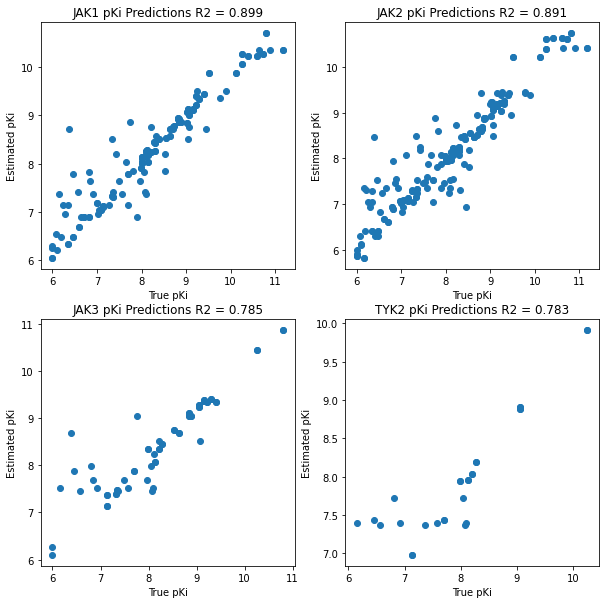

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2)

fig.set_figheight(10)
fig.set_figwidth(10)

ax[0][0].scatter(jak1_true_values, jak1_estimated_values)
ax[0][0].set_title("JAK1 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(jak1_true_values, jak1_estimated_values))))
ax[0][0].set_xlabel("True pKi")
ax[0][0].set_ylabel("Estimated pKi")

ax[0][1].scatter(jak2_true_values, jak2_estimated_values)
ax[0][1].set_title("JAK2 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(jak2_true_values, jak2_estimated_values))))
ax[0][1].set_xlabel("True pKi")
ax[0][1].set_ylabel("Estimated pKi")

ax[1][0].scatter(jak3_true_values, jak3_estimated_values)
ax[1][0].set_title("JAK3 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(jak3_true_values, jak3_estimated_values))))
ax[1][0].set_xlabel("True pKi")
ax[1][0].set_ylabel("Estimated pKi")

ax[1][1].scatter(tyk2_true_values, tyk2_estimated_values)
ax[1][1].set_title("TYK2 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(tyk2_true_values, tyk2_estimated_values))))
ax[1][1].set_xlabel("True pKi")
ax[1][1].set_ylabel("Estimated pKi")

### In absolute terms, the CNN models trained for each kinase have the following mean errors when predicting pKi:

In [9]:
print("JAK1 Error:", round(data_utils.get_MAE(jak1_true_values, jak1_estimated_values), 2))
print("JAK2 Error:", round(data_utils.get_MAE(jak2_true_values, jak2_estimated_values), 2))
print("JAK3 Error:", round(data_utils.get_MAE(jak3_true_values, jak3_estimated_values), 2))
print("TYK2 Error:", round(data_utils.get_MAE(tyk2_true_values, tyk2_estimated_values), 2))

JAK1 Error: 0.22
JAK2 Error: 0.24
JAK3 Error: 0.31
TYK2 Error: 0.34


### Model 1b - One CNN for all Kinases Using an Encoding Variable
All SMILES input data will be the same one-hot encoded format, but the tensor will be pre-pended with a feature to encode for the target kinase. The format of the vector itself will be a one-hot vector, so this will necessitate creating a larger input volume. This will involve adding 4 new features, one for each of the kinases. 

In [10]:
# Make dataset with kinases one-hot encoded as a prefix to the SMILES data
kinase_encoded_dataloader = data_utils.make_kinase_encoded_SMILES_dataloader(data, batch_size=1)

# Make model 
all_kinase_model = models.SMILES_CNN(60, 121)

# Train
if 0:
  models.train_CNN(all_kinase_model, kinase_encoded_dataloader)

### Now I will evaluate the unified model's ability to predict the pKi for a given kinase, assuming it is properly encoded. 
I will still use the separate validation datasets for each kinase (from above) so we can see if the all-kinase model does better or worse at predicting an individual kinases inhibition than the bespoke models do.

In [11]:
# Load trained weights for inference
all_kinase_model.load_state_dict(torch.load("/content/drive/MyDrive/challenge/trained/all_kinase/95_epochs.pt"))

# Do inference for all kinase types but using the unified model
jak1_all_kinase_true_values, jak1_all_kinase_estimated_values = data_utils.evaluate_model(all_kinase_model, jak1_test_data, data, encode_kinase=True)
jak2_all_kinase_true_values, jak2_all_kinase_estimated_values = data_utils.evaluate_model(all_kinase_model, jak2_test_data, data, encode_kinase=True)
jak3_all_kinase_true_values, jak3_all_kinase_estimated_values = data_utils.evaluate_model(all_kinase_model, jak3_test_data, data, encode_kinase=True)
tyk2_all_kinase_true_values, tyk2_all_kinase_estimated_values = data_utils.evaluate_model(all_kinase_model, tyk2_test_data, data, encode_kinase=True)

Text(0, 0.5, 'Estimated pKi')

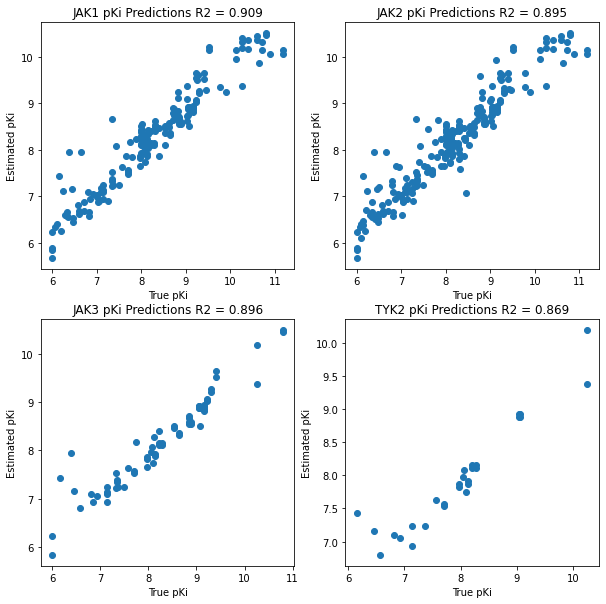

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2)

fig.set_figheight(10)
fig.set_figwidth(10)

ax[0][0].scatter(jak1_all_kinase_true_values, jak1_all_kinase_estimated_values)
ax[0][0].set_title("JAK1 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(jak1_all_kinase_true_values, jak1_all_kinase_estimated_values))))
ax[0][0].set_xlabel("True pKi")
ax[0][0].set_ylabel("Estimated pKi")

ax[0][1].scatter(jak2_all_kinase_true_values, jak2_all_kinase_estimated_values)
ax[0][1].set_title("JAK2 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(jak2_all_kinase_true_values, jak2_all_kinase_estimated_values))))
ax[0][1].set_xlabel("True pKi")
ax[0][1].set_ylabel("Estimated pKi")

ax[1][0].scatter(jak3_all_kinase_true_values, jak3_all_kinase_estimated_values)
ax[1][0].set_title("JAK3 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(jak3_all_kinase_true_values, jak3_all_kinase_estimated_values))))
ax[1][0].set_xlabel("True pKi")
ax[1][0].set_ylabel("Estimated pKi")

ax[1][1].scatter(tyk2_all_kinase_true_values, tyk2_all_kinase_estimated_values)
ax[1][1].set_title("TYK2 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(tyk2_all_kinase_true_values, tyk2_all_kinase_estimated_values))))
ax[1][1].set_xlabel("True pKi")
ax[1][1].set_ylabel("Estimated pKi")

### The 1D CNN with a one-hot encoded token specifying the kinase outperformed each model learning independently, with better agreement between predicted and actual pKi values on the holdout data and lower mean absolute error:

In [13]:
print("JAK1 Error:", round(data_utils.get_MAE(jak1_all_kinase_true_values, jak1_all_kinase_estimated_values), 2))
print("JAK2 Error:", round(data_utils.get_MAE(jak2_all_kinase_true_values, jak2_all_kinase_estimated_values), 2))
print("JAK3 Error:", round(data_utils.get_MAE(jak3_all_kinase_true_values, jak3_all_kinase_estimated_values), 2))
print("TYK2 Error:", round(data_utils.get_MAE(tyk2_all_kinase_true_values, tyk2_all_kinase_estimated_values), 2))

JAK1 Error: 0.26
JAK2 Error: 0.28
JAK3 Error: 0.24
TYK2 Error: 0.24


# Model 2: Transformer
In the above analysis, I showed that a fairly simple Convolutional Neural Network operating on one-hot encoded SMILES inputs can achieve good prediction results on the pKi for arbitrary kinases in our set. Crucially, I was also able to show that a single model, even a simple one, can learn from all kinases. This is refelected in the fact that Mean Absolute Error on each kinase's inference using the joint model was better compared to the individually-trained models.    

I now want to extend these concepts to a more sophisticated architecture to determine if we can improve the prediction accuracy further. Transformers are well-suited for sequence-to-sequence models, but can also be used for cases in which the input is sequential and the output is not.


Transfomers are fundamentally encoder-decoder models, and when the target is a sequence, the decoded values are produced autoregressively by decoding the past decoder outputs, until a special < stop > token is reached.

### Encoder-Only Model
Since the output in this case is a scalar value, I will take advantage of the transformer encoder's ability to represent sequence relationships, but I will not implement a decoder. Some well-known transformers, potentially most-notably BERT, are in fact encoder-only models.

Therefore, I will implement a transfomer encoder with multi-head attention blocks. The "decoder" will simply be a dense layer that unravels the attention matrix learned in the encoder, and regresses onto the pKi output value.


### Input Format Assumption - One Hot SMILES 
In natural language modelling tasks, word embeddings such as word2vec are a critical part of the success of transformers. This is because one-hot encoding the entire English language first of all would be impractical, but additionally because NLP practicioners want words with similar semantic context to have similar valence in the model, such as *Dog* and *Canine* which one-hot encoding would not capture. 

I will assume since the SMILES format is a limited vocabulary, and because the semantic sililarity between a double bond and Carbon for example is not informative, One Hot encoding is sufficient. The inputs will be encoded in a similar manner as in the all-kinase CNN, in which they are prefixed by a one-hot encoding of the kinase which was successful in the CNN context.


## Please see implementation of transformer in models.SMILESSequenceModel

In [14]:
# Make dataloader with large batch size for stable transformer training
kinase_encoded_dataloader = data_utils.make_kinase_encoded_SMILES_dataloader(data, batch_size=1024)

# Instantiate model with 6 attention heads per block and 8 blocks
all_kinase_transformer = models.SMILESSequenceModel(6, 8)

if 0:
  models.train_transformer(all_kinase_transformer, kinase_encoded_dataloader)

In [15]:
all_kinase_transformer = models.SMILESSequenceModel(6, 8)

# Load trained weights for inference
all_kinase_transformer.load_state_dict(torch.load("/content/drive/MyDrive/challenge/trained/all_kinase_transformer/7400_epochs.pt"))

# Do inference for all kinase types but using the unified transformer model
jak1_all_kinase_transformer_true_values, jak1_all_kinase_transformer_estimated_values = data_utils.evaluate_model(all_kinase_transformer, jak1_test_data, data, encode_kinase=True)
jak2_all_kinase_transformer_true_values, jak2_all_kinase_transformer_estimated_values = data_utils.evaluate_model(all_kinase_transformer, jak2_test_data, data, encode_kinase=True)
jak3_all_kinase_transformer_true_values, jak3_all_kinase_transformer_estimated_values = data_utils.evaluate_model(all_kinase_transformer, jak3_test_data, data, encode_kinase=True)
tyk2_all_kinase_transformer_true_values, tyk2_all_kinase_transformer_estimated_values = data_utils.evaluate_model(all_kinase_transformer, tyk2_test_data, data, encode_kinase=True)

Text(0, 0.5, 'Estimated pKi')

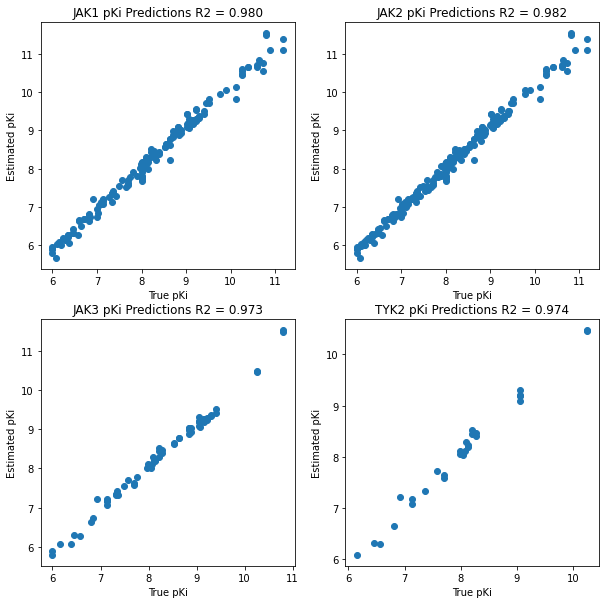

In [16]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=2)

fig.set_figheight(10)
fig.set_figwidth(10)

ax[0][0].scatter(jak1_all_kinase_transformer_true_values, jak1_all_kinase_transformer_estimated_values)
ax[0][0].set_title("JAK1 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(jak1_all_kinase_transformer_true_values, jak1_all_kinase_transformer_estimated_values))))
ax[0][0].set_xlabel("True pKi")
ax[0][0].set_ylabel("Estimated pKi")

ax[0][1].scatter(jak2_all_kinase_transformer_true_values, jak2_all_kinase_transformer_estimated_values)
ax[0][1].set_title("JAK2 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(jak2_all_kinase_transformer_true_values, jak2_all_kinase_transformer_estimated_values))))
ax[0][1].set_xlabel("True pKi")
ax[0][1].set_ylabel("Estimated pKi")

ax[1][0].scatter(jak3_all_kinase_transformer_true_values, jak3_all_kinase_transformer_estimated_values)
ax[1][0].set_title("JAK3 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(jak3_all_kinase_transformer_true_values, jak3_all_kinase_transformer_estimated_values))))
ax[1][0].set_xlabel("True pKi")
ax[1][0].set_ylabel("Estimated pKi")

ax[1][1].scatter(tyk2_all_kinase_transformer_true_values, tyk2_all_kinase_transformer_estimated_values)
ax[1][1].set_title("TYK2 pKi Predictions {}".format("R2 = {:.3f}".format(metrics.r2_score(tyk2_all_kinase_transformer_true_values, tyk2_all_kinase_transformer_estimated_values))))
ax[1][1].set_xlabel("True pKi")
ax[1][1].set_ylabel("Estimated pKi")


In [17]:
print("JAK1 Error:", round(data_utils.get_MAE(jak1_all_kinase_transformer_true_values, jak1_all_kinase_transformer_estimated_values), 2))
print("JAK2 Error:", round(data_utils.get_MAE(jak2_all_kinase_transformer_true_values, jak2_all_kinase_transformer_estimated_values), 2))
print("JAK3 Error:", round(data_utils.get_MAE(jak3_all_kinase_transformer_true_values, jak3_all_kinase_transformer_estimated_values), 2))
print("TYK2 Error:", round(data_utils.get_MAE(tyk2_all_kinase_transformer_true_values, tyk2_all_kinase_transformer_estimated_values), 2))

JAK1 Error: 0.13
JAK2 Error: 0.12
JAK3 Error: 0.12
TYK2 Error: 0.14


### Comparison of Methods

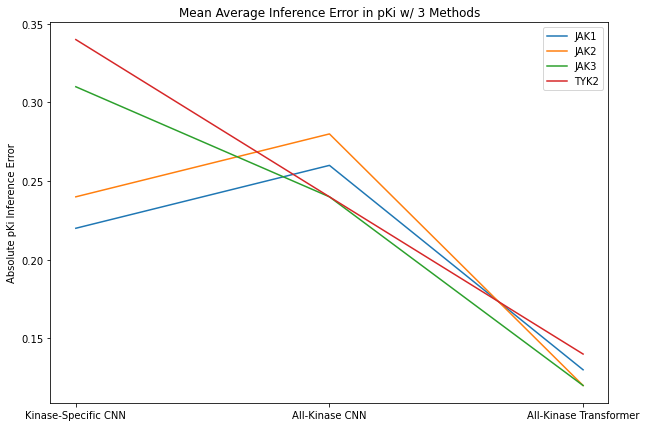

In [31]:
jak1 = [0.22, 0.26, 0.13]
jak2 = [0.24, 0.28, 0.12]
jak3 = [0.31, 0.24, 0.12]
tyk2 = [0.34, 0.24, 0.14]
index = [0,1,2]

plt.figure(figsize=(10,7))
plt.title("Mean Average Inference Error in pKi w/ 3 Methods")
plt.ylabel("Absolute pKi Inference Error")
plt.xticks(index, ["Kinase-Specific CNN", "All-Kinase CNN", "All-Kinase Transformer"])
plt.plot(index, jak1, label="JAK1")
plt.plot(index, jak2, label="JAK2")
plt.plot(index, jak3, label="JAK3")
plt.plot(index, tyk2, label="TYK2")
plt.legend()

## Training Details
Training transformers notoriously comes with difficulties in stability and sensitivity to learning rate. Four factors are known to help with transformer training, which are:
- Residual skip connections (implemented within the torch.nn EncoderLayer implementation, so I did not have to worry about implementing)
- Layer normalization (also implemented within the torch.nn EncoderLayer implementation)
- Learning rate warm-up
- Large batch size

I found success in using a linearlly increasing learning rate, starting at 0.0 and increasing to 1e-4 over 5k iterations, and then proceeding with the remaining training iterations at 1e-4.

Batch size was 1024 samples, a large proportion of the total dataset so that epochs only included ~10 iterations.

## Hypothetical Deployment Notes
### Scale
Transfomers have been shown to scale well with size and compute resource, with many architectures for NLP reaching model sizes in the many billions of parameters. The compute resources to support these large models are not trivial, so an important consideration for a hypothetical production implementation is how large the model needs to be. If the SMILES sequences are relatively short, it is possible that an even smaller transformer could be used. Longer sequences may merit the use of larger models however.

### Serving
The paradigm for serving a model like this would be highly dependent on how it is used. I will present two cases:

#### Case 1: Internal Research Tool
Assuming a research facility was serving and using this model for internal research, it would likely be possible to schedule access and batch requests in a more predictible manner. This would minimize some of the considerations with load balancing, and processing large batches of SMILES sequences could optmize hardware / cloud service usage.

#### Case 2: User-facing Platform
If this model was available as a service to users around the world, the serving becomes more complex. Large batched inputs is less possible if the requests are coming from different users, and potentially at very different times of the day. Considering how this applies to AWS for example, hosting this model in a serverless approach (for example AWS Lambda functions) would probably be preferable because of built-in load balancing and the ability to dynamically allocate more hardware based on usage. This also would have the advantage that machines can easily be started up and shut down based on demand, to avoid incurring cost when inference is not occuring.